In [349]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Interactive widget
from ipywidgets import interact



# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [350]:
url="/content/co2_mm_mlo.csv"
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')
df=pd.read_csv(url,skiprows=72,names=names,index_col=False)
df

year  month  decimal date  average  deseasonalized  ndays  sdev   unc
0    1960     10     1960.7896   313.83          316.83     -1 -9.99 -0.99
1    1960     11     1960.8743   315.00          316.88     -1 -9.99 -0.99
2    1960     12     1960.9563   316.19          316.96     -1 -9.99 -0.99
3    1961      1     1961.0411   316.89          316.86     -1 -9.99 -0.99
4    1961      2     1961.1260   317.70          317.08     -1 -9.99 -0.99
..    ...    ...           ...      ...             ...    ...   ...   ...
756  2023     10     2023.7917   418.82          422.12     27  0.47  0.17
757  2023     11     2023.8750   420.46          422.46     21  0.91  0.38
758  2023     12     2023.9583   421.86          422.58     20  0.68  0.29
759  2024      1     2024.0417   422.80          422.45     27  0.73  0.27
760  2024      2     2024.1250   424.55          423.61     18  1.31  0.59

[761 rows x 8 columns]

In [351]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [352]:
df.head()

year  month  decimal date  average  deseasonalized  ndays  sdev  \
1960-10-01  1960     10     1960.7896   313.83          316.83     -1 -9.99   
1960-11-01  1960     11     1960.8743   315.00          316.88     -1 -9.99   
1960-12-01  1960     12     1960.9563   316.19          316.96     -1 -9.99   
1961-01-01  1961      1     1961.0411   316.89          316.86     -1 -9.99   
1961-02-01  1961      2     1961.1260   317.70          317.08     -1 -9.99   

             unc  
1960-10-01 -0.99  
1960-11-01 -0.99  
1960-12-01 -0.99  
1961-01-01 -0.99  
1961-02-01 -0.99

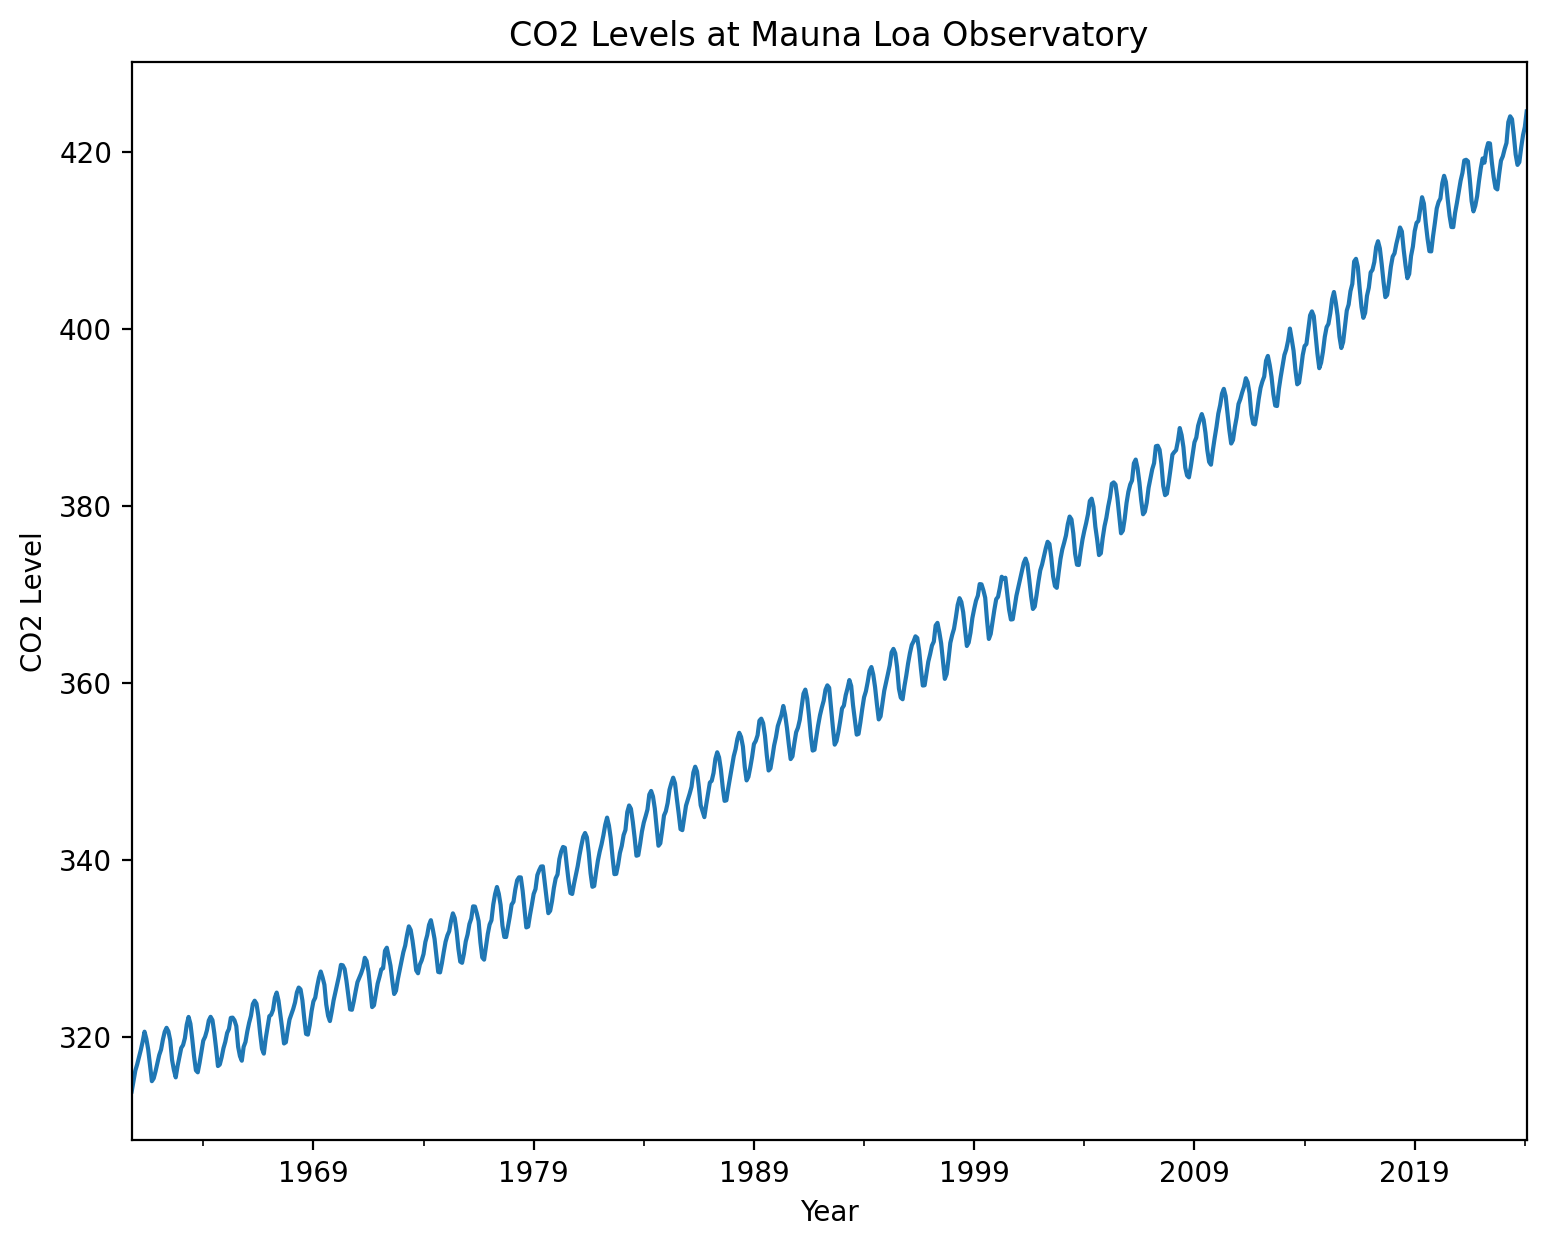

In [353]:
df.average.plot(figsize=(9,7),title="CO2 Levels at Mauna Loa Observatory")
plt.xlabel("Year")
plt.ylabel("CO2 Level")
plt.show()

In [354]:
# Create X and y

# X = months since first measurement
X = np.array(range(len(df)))
y = df.average.values


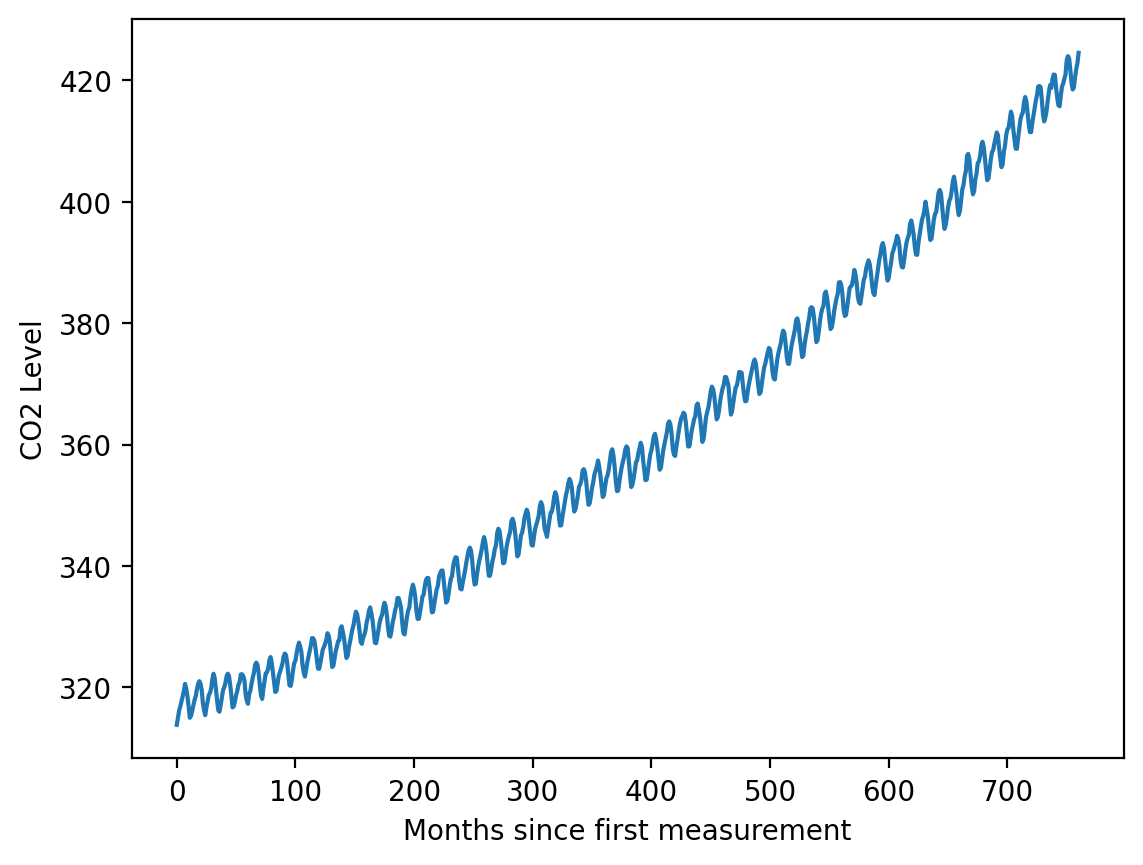

In [355]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')
plt.show()

## Normalise the Dataset

In [356]:
# Normalize X and y

s1 = StandardScaler()
s2 = StandardScaler()

X_norm = s1.fit_transform(X.reshape(-1,1))
y_norm = s2.fit_transform(y.reshape(-1,1))
print(f"Shape of X_norm = {X_norm.shape} and that of y_norm ={y_norm.shape}")

Shape of X_norm = (761, 1) and that of y_norm =(761, 1)


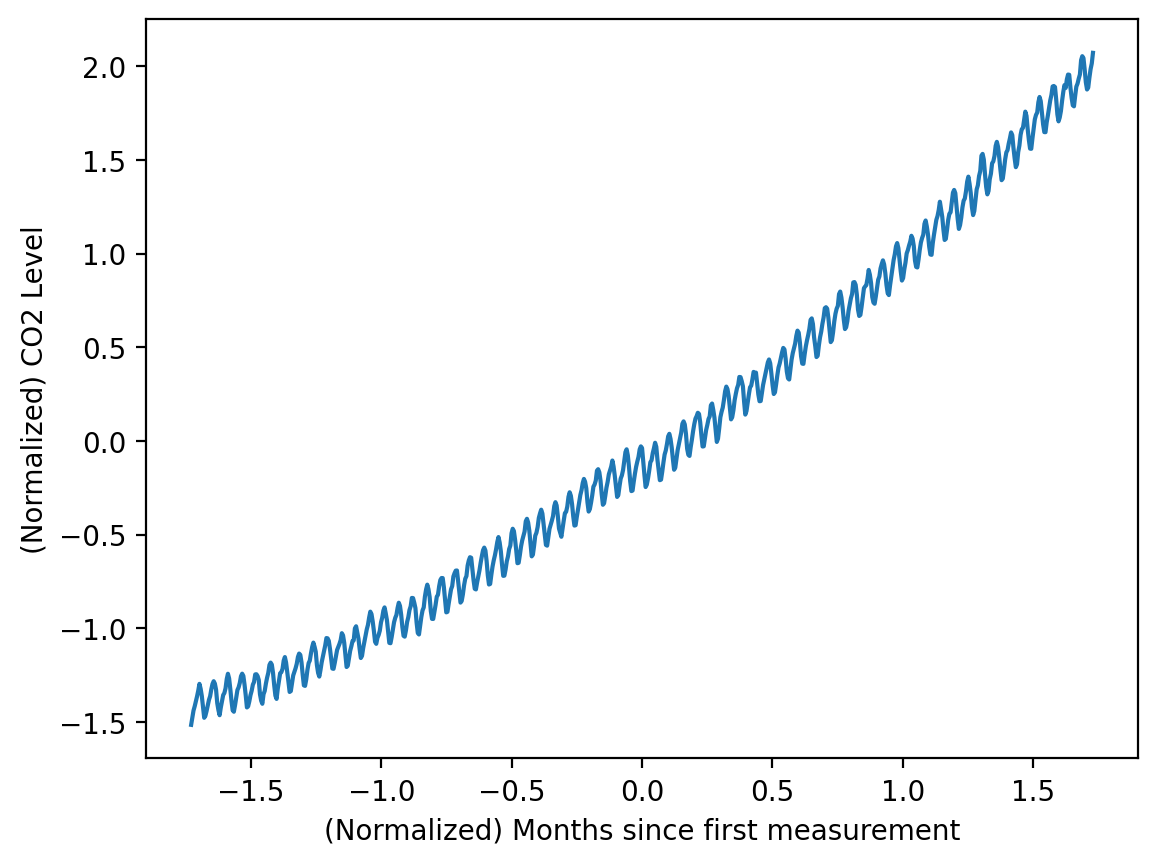

In [357]:
plt.plot(X_norm, y_norm)
plt.xlabel('(Normalized) Months since first measurement')
plt.ylabel('(Normalized) CO2 Level')
plt.show()

# We'll now figure out how to use first K-Months to predict the value of next T months.

In [358]:
def create_data(K,T,y):
 X_data,y_data=[],[]
 for i in range(len(y)-K-T+1):
  X_data.append(y[i:i+K])
  y_data.append(y[i+K:i+K+T])
 X_data=np.array(X_data)
 y_data=np.array(y_data)
 return(X_data,y_data)


### Splitting first 550 samples into train and rest into test.

In [359]:
X_train=X[:550]
X_test=X[550:]
y_train=y[:550]
y_test=y[550:]
y_train_tensor=torch.tensor(y_train,dtype=torch.float32)
K=5
T=2
print(f"Shape of X_train ={X_train.shape} and shape of y={y_train.shape}")

Shape of X_train =(550,) and shape of y=(550,)


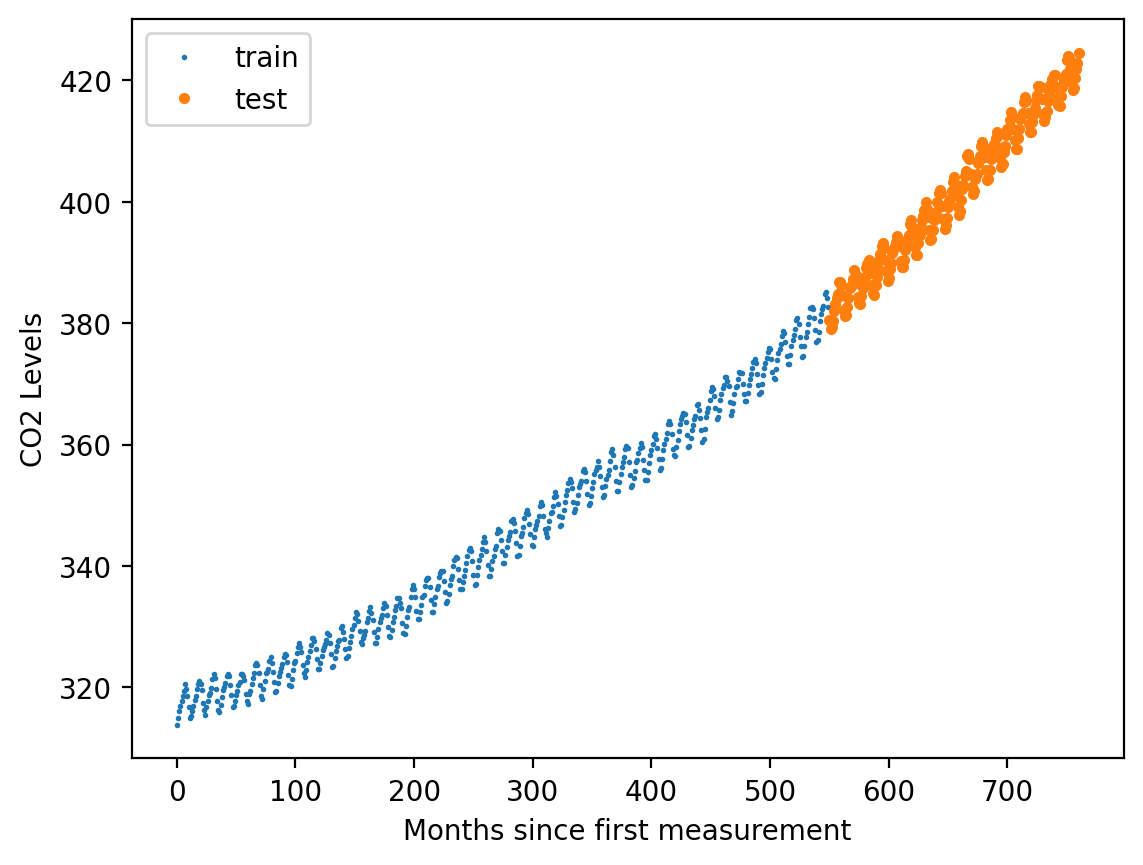

In [360]:
plt.plot(X_train, y_train, 'o', label='train', markersize=1)
plt.plot(X_test, y_test, 'o', label='test', ms=3)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Levels')
plt.legend()
plt.show()

### Grouping the data

In [361]:
X_train_data,y_train_data=create_data(K,T,y_train)
X_train_data_tensor=torch.tensor(X_train_data,dtype=torch.float32)
y_train_data_tensor=torch.tensor(y_train_data,dtype=torch.float32)
print(f"Size of X_train_data_tensor= {X_train_data_tensor.shape} and that of y_train_data_tensor={y_train_data_tensor.shape}")

Size of X_train_data_tensor= torch.Size([544, 5]) and that of y_train_data_tensor=torch.Size([544, 2])


##Building The Model

In [362]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)# 1st hidden layer
        self.relu = nn.ReLU()# Relu-Activation
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)# 2nd hidden layer
        self.fc3=nn.Linear(hidden_size_2,hidden_size_3)
        self.fc4=nn.Linear(hidden_size_3,T)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out=self.relu(out)
        out=self.fc3(out)
        out=self.relu(out)
        out=self.fc4(out)
        return out

input_size=X_train_data_tensor.shape[1]
hidden_size_1=128
hidden_size_2=64
hidden_size_3=32


model=NeuralNet(input_size,hidden_size_1)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [363]:
## Train the model


# Training loop
for epoch in range(200):
    # Forward pass
    outputs = model(X_train_data_tensor)

    # Compute the loss
    loss = criterion(outputs, y_train_data_tensor)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 115165.46875
Epoch 10, Loss: 83392.9609375
Epoch 20, Loss: 36054.9375
Epoch 30, Loss: 1598.0260009765625
Epoch 40, Loss: 3094.490234375
Epoch 50, Loss: 861.3016357421875
Epoch 60, Loss: 252.6106414794922
Epoch 70, Loss: 186.39947509765625
Epoch 80, Loss: 18.171606063842773
Epoch 90, Loss: 26.38384246826172
Epoch 100, Loss: 16.679100036621094
Epoch 110, Loss: 8.617307662963867
Epoch 120, Loss: 9.296575546264648
Epoch 130, Loss: 8.893058776855469
Epoch 140, Loss: 8.620674133300781
Epoch 150, Loss: 8.53240966796875
Epoch 160, Loss: 8.5378999710083
Epoch 170, Loss: 8.538482666015625
Epoch 180, Loss: 8.527655601501465
Epoch 190, Loss: 8.527112007141113


## Testing the Model

In [364]:
X_test_data,y_test_data=create_data(K,T,y_test)
X_test_data_tensor=torch.tensor(X_test_data,dtype=torch.float32)
y_test_data_tensor=torch.tensor(y_test_data,dtype=torch.float32)
y_test_data_tensor.shape

torch.Size([205, 2])

## Forecasting

### Performing on a dummy function

In [365]:
def forecast(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values

  for i in range(0,len(y)-K-T+1,T):
    #print(y[i:i+k])
    input=output_values[i:i+k]# Taking k-sized arrays from the predictions
    print(f"input= {input}")
    T_pred=model(input)# Training it on the k-sized arrays
    output_values=torch.cat((output_values,T_pred),dim=0)# Appending the first prediction
    print(f"output= {output_values}")
  return(output_values)


y_dummy=np.arange(1,11,1)

forecast(model,y_dummy,K,T)

input= tensor([1., 2., 3., 4., 5.])
output= tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 2.9349, 2.9211],
       grad_fn=<CatBackward0>)
input= tensor([3.0000, 4.0000, 5.0000, 2.9349, 2.9211], grad_fn=<SliceBackward0>)
output= tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 2.9349, 2.9211, 3.6157, 3.6938],
       grad_fn=<CatBackward0>)


tensor([1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 2.9349, 2.9211, 3.6157, 3.6938],
       grad_fn=<CatBackward0>)

### Performing on the actual dataset

In [366]:
def forecast_1(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values
  with torch.no_grad():
    for i in range(0,len(y)-K-T+1,T):

      input=output_values[i:i+k]# Taking k-sized arrays from the predictions
      T_pred=model(input)# Training it on the k-sized arrays
      output_values=torch.cat((output_values,T_pred),dim=0)# Appending the first prediction
    return(output_values)

def forecast_2(model,y,k,T):
  output_values=torch.tensor(y[:k],dtype=torch.float32)# Initial K values
  with torch.no_grad():
    for i in range(0,len(y)-K-T+1):

      input=output_values[i:i+k]# Taking k-sized arrays from the predictions
      T_pred=model(input)# Training it on the k-sized arrays
      output_values=torch.cat((output_values,T_pred[0].unsqueeze(0)),dim=0)# Appending the first prediction
    return(output_values)

y_pred=forecast_2(model,y_test,K,T)
y_pred_np=y_pred.numpy()
y_test[:len(y_pred_np)].shape

(210,)

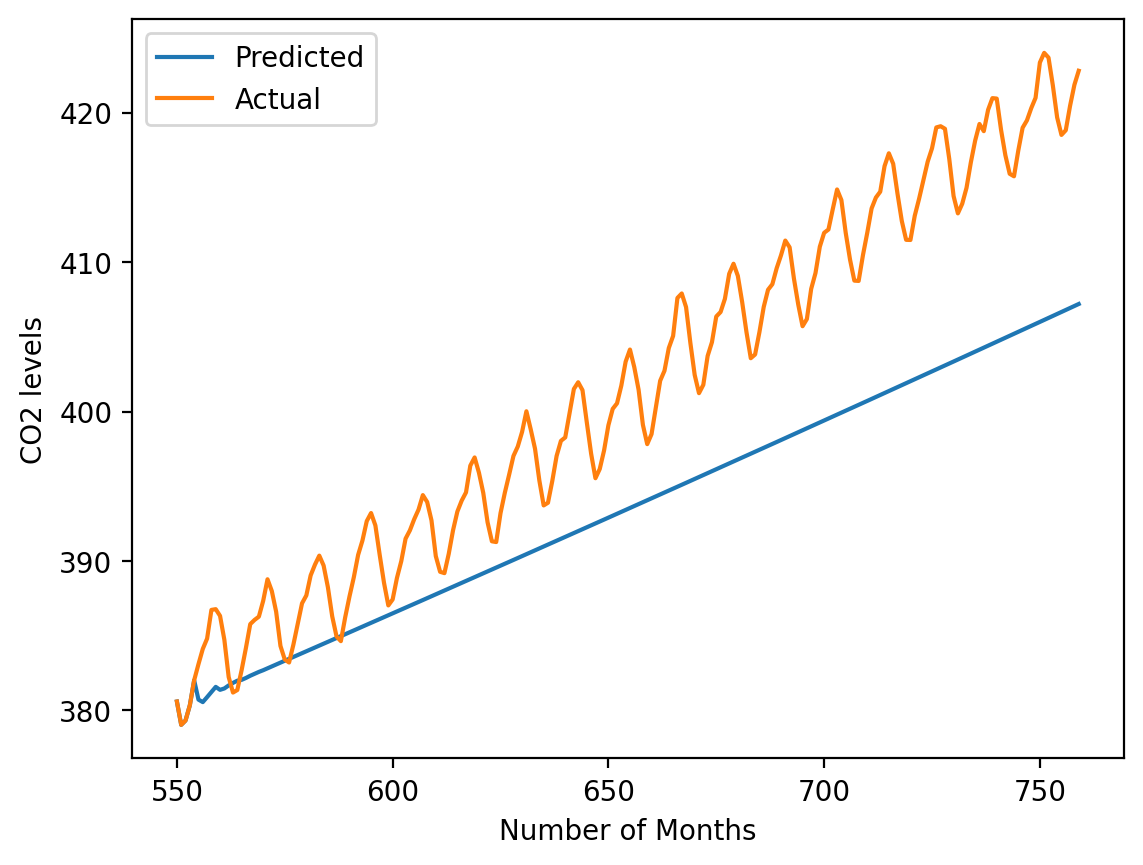

In [371]:
plt.plot(X_test[:len(y_pred_np)],y_pred_np,label="Predicted")
plt.plot(X_test[:len(y_pred_np)],y_test[:len(y_pred_np)],label="Actual")
plt.xlabel("Number of Months")
plt.ylabel("CO2 levels")
plt.legend()
plt.show()
